An example to demonstrate window dynamic mode decomposition

We take a 2D time varying system given by dx/dt = A(t)x
where x = [x1,x2]', A(t) = [0,w(t);-w(t),0], 
w(t)=1+epsilon*t, epsilon=0.1. The slowly time varying eigenvlaues of A(t)
are pure imaginary, +(1+0.1t)j and -(1+0.1t)j, where j is the imaginary unit.

At time step k, define two matrix X(k) = [x(k-w+1),x(k-w+2),...,x(k)], 
Y(k) = [y(k-w+1),y(k-w+2),...,y(k)], that contain the recent w snapshot pairs 
from a finite time window, we would like to compute Ak = Yk*pinv(Xk). This can 
be done by brute-force mini-batch DMD, and by efficient rank-2 updating window 
DMD algrithm. For window DMD, at time k+1, we need to forget the old snapshot 
pair xold = x(k-w+1), yold = y(k-w+1), and remember the new snapshot pair xnew 
= x(k+1), ynew = y(k+1). Mini-batch DMD computes DMD matrix by taking the 
pseudo-inverse directly. Window DMD computes the DMD matrix by using efficient 
rank-2 update idea.

We compare the performance of window DMD with the brute-force mini-batch DMD
approach in terms of tracking time varying eigenvalues, by comparison with 
the analytical solution. They should agree with each other (up to machine 
round-offer errors).
    
Authors: 
    Hao Zhang
    Clarence W. Rowley
    
References:
    Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta. "Online dynamic mode decomposition for time-varying systems." SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.
        
Date created: April 2017

In [10]:
!pip install -r requirements.txt

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from odmd import WindowDMD
from scipy.integrate import odeint

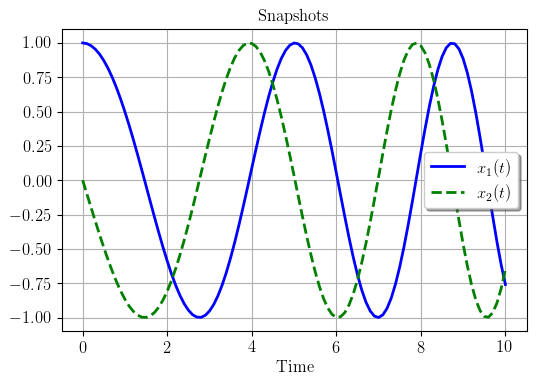

In [7]:
# define dynamics
epsilon = 1e-1
def dyn(x, t):
    x1, x2 = x
    dxdt = [(1+epsilon*t)*x2, -(1+epsilon*t)*x1]
    return dxdt

# integrate from initial condition [1,0]
tspan = np.linspace(0, 10, 101)
dt = 0.1
x0 = [1, 0]
xsol = odeint(dyn, x0, tspan).T
# extract snapshots
x, y = xsol[:, :-1], xsol[:, 1:]
t = tspan[1:]
# true dynamics, true eigenvalues
n, m = len(x[:, 0]), len(x[0, :])
A = np.empty((n, n, m))
evals = np.empty((n, m), dtype=complex)
for k in range(m):
    A[:, :, k] = np.array([[0, (1+epsilon*t[k])], [-(1+epsilon*t[k]), 0]])
    evals[:, k] = np.linalg.eigvals(A[:, :, k])

# visualize snapshots
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(6,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(tspan, xsol[0, :], 'b-', linewidth=2.0,  label='$x_1(t)$')
plt.plot(tspan, xsol[1, :], 'g--', linewidth=2.0,  label='$x_2(t)$')
plt.legend(loc='best', fontsize=12, shadow=True)
plt.xlabel('Time', fontsize=12)
plt.title('Snapshots', fontsize=12)
plt.tick_params(labelsize=12)
plt.grid()
plt.show()

Mini-batch DMD, w = 10, time = 0.029668092727661133 secs
Window DMD, w=10, weighting = 1, time = 0.02937769889831543 secs
Window DMD, w=10, weighting = 0.5, time = 0.030341148376464844 secs


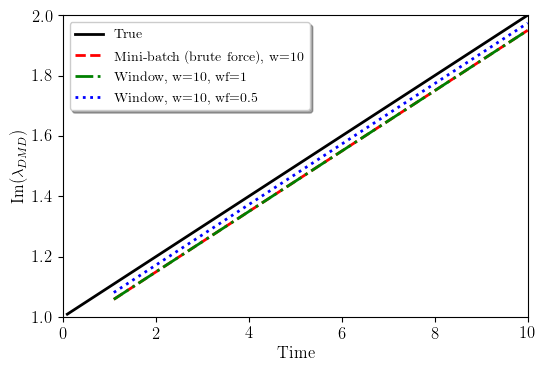

In [6]:
# mini-batch DMD, w = 10
w = 10
AminibatchDMD = np.empty((n, n, m))
evalsminibatchDMD = np.empty((n, m), dtype=complex)
start = time.time()
for k in range(w, m):
    AminibatchDMD[:, :, k] = y[:, k-w+1:k +1].dot(np.linalg.pinv(x[:, k-w+1:k+1]))
    evalsminibatchDMD[:, k] = np.log(np.linalg.eigvals(AminibatchDMD[:, :, k]))/dt
end = time.time()
print("Mini-batch DMD, w = 10, time = " + str(end-start) + " secs")


# Window DMD, w = 10, weighting = 1
evalswindowDMD1 = np.empty((n, m), dtype=complex)
wdmd = WindowDMD(n, w, 1)
wdmd.initialize(x[:, :w], y[:, :w])
start = time.time()
for k in range(w, m):
    wdmd.update(x[:, k], y[:, k])
    evalswindowDMD1[:, k] = np.log(np.linalg.eigvals(wdmd.A))/dt
end = time.time()
print("Window DMD, w=10, weighting = 1, time = " + str(end-start) + " secs")


# Window DMD, w = 10, weighting = 0.5
evalswindowDMD2 = np.empty((n, m), dtype=complex)
wdmd = WindowDMD(n, w, 0.5)
wdmd.initialize(x[:, :w], y[:, :w])
start = time.time()
for k in range(w, m):
    wdmd.update(x[:, k], y[:, k])
    evalswindowDMD2[:, k] = np.log(np.linalg.eigvals(wdmd.A))/dt
end = time.time()
print("Window DMD, w=10, weighting = 0.5, time = " + str(end-start) + " secs")


# visualize true, batch, window
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(6, 4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(t, np.imag(evals[0, :]), 'k-', label='True', linewidth=2.0)
plt.plot(t[w:], np.imag(evalsminibatchDMD[0, w:]), 'r--',
         label='Mini-batch (brute force), w=10', linewidth=2.0)
plt.plot(t[w:], np.imag(evalswindowDMD1[0, w:]), 'g-.',
         label='Window, w=10, wf=1', linewidth=2.0)
plt.plot(t[w:], np.imag(evalswindowDMD2[0, w:]), 'b:',
         label='Window, w=10, wf=0.5', linewidth=2.0)
plt.tick_params(labelsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Im($\lambda_{DMD}$)', fontsize=12)
plt.legend(loc='best', fontsize=10, shadow=True)
plt.xlim([0, 10])
plt.ylim([1, 2])
plt.show()